# L'algoritmo CYK


In [ ]:
from liblet import Grammar, Production, Derivation, ProductionGraph, CYKTable, closure, union_of, ε

## Dalla precedente lezione

In [ ]:
# L'algoritmo CYK

def offline(fill, n):
  R = CYKTable()
  for l in range(1, n + 1):
    for i in range(1, n - l + 2): 
      R[i, l] = fill(R, i, l)
  return R

def cyk_fill(G, INPUT):
  def fill(R, i, l):
    res = set()
    if l == 1:
      for A, (a,) in filter(Production.such_that(rhs_len = 1), G.P): 
        if a == INPUT[i - 1]: res.add(A)
    else:
      for k in range(1, l):
        for A, (B, C) in filter(Production.such_that(rhs_len = 2), G.P):
          if B in R[i, k] and C in R[i + k, l - k]: res.add(A)
    return res
  return fill

def cyk(G, INPUT):
 return offline(cyk_fill(G, INPUT), len(INPUT))   

In [ ]:
# Eliminazione simboli improduttivi e irraggiungibili

def remove_unproductive_unreachable(G):
  def find_productive(G):
    @closure
    def find(prod):
      return prod | {A for A, α in G.P if set(α) <= prod}
    return find(G.T)
  def find_reachable(G):
    @closure
    def find(reach):
      return reach | union_of(set(α) for A, α in G.P if A in reach)
    return find({G.S})
  Gp = G.restrict_to(find_productive(G))
  return Gp.restrict_to(find_reachable(Gp))

In [ ]:
# Eliminazione ε-regole

@closure
def replace_in_rhs(G, A):
  Ap = A + '′'
  prods = set()
  for B, β in G.P:
    if A in β:
      pos = β.index(A)
      rhs = β[:pos] + β[pos + 1:]
      if len(rhs) == 0: rhs = (ε, )
      prods.add(Production(B, rhs))
      prods.add(Production(B, β[:pos] + (Ap, ) + β[pos + 1:]))
    else:
      prods.add(Production(B, β))
  return Grammar(G.N | {Ap}, G.T, prods, G.S)

@closure
def inline_ε_rules(G_seen):
  G, seen = G_seen
  for A in G.N - seen:
    if (ε, ) in G.alternatives(A):
      return replace_in_rhs(G, A), seen | {A}
  return G, seen

def eliminate_ε_rules(G):
  Gp, _ = inline_ε_rules((G, set()))
  prods = set(Gp.P)
  for Ap in Gp.N - G.N:
    A = Ap[:-1]
    for α in set(Gp.alternatives(A)) - {(ε, )}:
      prods.add(Production(Ap, α))
  return Grammar(Gp.N, Gp.T, prods, Gp.S)

In [ ]:
# Eliminazione regole unitarie

def eliminate_unit_rules(G):
  @closure
  def eliminate(G_seen):
    G, seen = G_seen
    for P in set(filter(Production.such_that(rhs_len = 1), G.P)) - seen:
      A, (B, ) = P
      if B in G.N:
        prods = (set(G.P) | {Production(A, α) for α in G.alternatives(B)}) - {P}
        return Grammar(G.N, G.T, prods, G.S), seen | {P}
    return G, seen
  return eliminate((G, set()))[0]

In [ ]:
# Eliminazione terminali non solitari

def transform_nonsolitary(G):
  prods = set()
  for A, α in G.P:
    prods.add(Production(A, [f'N{x}' if x in G.T else x for x in α] if len(α) > 1 else α))
    prods |= {Production(f'N{x}', (x, )) for x in α if x in G.T and len(α) > 1}
  return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [ ]:
# Eliminazione lati destri lunghi

def make_binary(G):
  prods = set()
  for A, α in G.P:
    if len(α) > 2:
      Ai = f'{A}{1}'
      prods.add(Production(Ai, α[:2]))
      for i, Xi in enumerate(α[2:-1], 2):
          prods.add(Production(f'{A}{i}', (Ai, Xi)))
          Ai = f'{A}{i}'
      prods.add(Production(A, (Ai, α[-1])))
    else:
      prods.add(Production(A, α))
  return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [ ]:
# fig. 4.6, pag. 112

G = Grammar.from_string("""
Number -> Integer | Real
Integer -> Digit | Integer Digit
Real -> Integer Fraction Scale
Fraction -> . Integer
Scale -> e Sign Integer | Empty
Digit -> 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
Sign -> + | -
Empty -> ε
""")

## Parsing CYK con  G in forma CNF

In [ ]:
Gp = eliminate_unit_rules(eliminate_ε_rules(G))
Gp_clean = remove_unproductive_unreachable(Gp)
G_cnf = make_binary(transform_nonsolitary(Gp_clean))

In [ ]:
# fig. 4.16, pag. 123

INPUT = '32.5e+1'
R = cyk(G_cnf, INPUT)
R

## Una derivazione leftmost

Per ottenere una derivazione *leftmost* ragioniamo come per la funzione `fake_parse` della precedente sezione, ma invece di restituire un albero restituiamo l'indice della produzione in gioco (ottenuto invocando `G.P.index`)

In [ ]:
def get_leftmost_prods(G, R, INPUT):
  def prods(X, i, l):
    if l == 1:
      return [G.P.index(Production(X, (INPUT[i - 1],)))]
    for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
      for k in range(1, l):
        if B in R[i, k] and C in R[i + k, l - k]:
          return [G.P.index(Production(A, (B, C)))] + prods(B, i, k) + prods(C, i + k, l - k)
  return prods(G.S, 1, len(INPUT))

In [ ]:
leftmost_prods = get_leftmost_prods(G_cnf, R, INPUT)
leftmost_prods

[13, 9, 3, 32, 29, 10, 31, 0, 12, 11, 15, 21, 27]

In [ ]:
d = Derivation(G_cnf).leftmost(leftmost_prods)
d

Number -> Number1 Scale′ -> Integer Fraction Scale′ -> Integer Digit Fraction Scale′ -> 3 Digit Fraction Scale′ -> 3 2 Fraction Scale′ -> 3 2 N. Integer Scale′ -> 3 2 . Integer Scale′ -> 3 2 . 5 Scale′ -> 3 2 . 5 Scale′1 Integer -> 3 2 . 5 Ne Sign Integer -> 3 2 . 5 e Sign Integer -> 3 2 . 5 e + Integer -> 3 2 . 5 e + 1

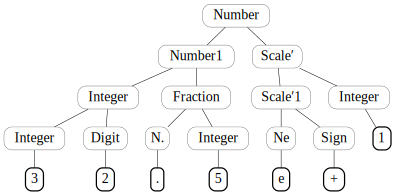

In [ ]:
ProductionGraph(d)

Come si possono ottenere le produzioni di una derivazione *rightomst*?

## Il parsing in G (non in CNF)? (Sez. 4.2.6)

Un primo requisito, per poter effettuare il parsing secondo le produzioni della grammatica originale è non eliminare i simboli improduttivi e irraggiungibili.

In [ ]:
# Non effettuiamo la pulizia

# Gp = eliminate_unit_rules(eliminate_ε_rules(G))
# Gp_clean = remove_unproductive_unreachable(Gp)
# G_cnf = make_binary(transform_nonsolitary(Gp_clean))

Gp_cnf = make_binary(transform_nonsolitary(Gp))
Gp_cnf.P

(Integer -> 5,
 Digit -> 0,
 Number -> Integer Digit,
 Real1 -> Integer Fraction,
 Integer -> Integer Digit,
 Digit -> 6,
 Scale -> Scale1 Integer,
 Real -> Integer Fraction,
 Number -> 0,
 Integer -> 0,
 Number -> 6,
 Integer -> 6,
 Number1 -> Integer Fraction,
 Fraction -> N. Integer,
 Empty -> ε,
 Scale′1 -> Ne Sign,
 Scale′ -> Scale′1 Integer,
 Number -> Number1 Scale′,
 Digit -> 4,
 Ne -> e,
 Scale -> ε,
 Digit -> 8,
 Number -> 4,
 Integer -> 4,
 Digit -> 1,
 Number -> 8,
 Sign -> +,
 Integer -> 8,
 Digit -> 3,
 Digit -> 7,
 Scale1 -> Ne Sign,
 Number -> 1,
 Digit -> 9,
 Integer -> 1,
 Sign -> -,
 Digit -> 2,
 Number -> 3,
 N. -> .,
 Integer -> 3,
 Digit -> 5,
 Integer -> 7,
 Number -> Integer Fraction,
 Number -> 7,
 Number -> 9,
 Integer -> 9,
 Real -> Real1 Scale′,
 Number -> 2,
 Integer -> 2,
 Number -> 5)

Ora calcoliamo la tabella `Rp` e la completiamo con le ε-regole

In [ ]:
# Otteniamo Rp tramite il parsing rispetto alla grammatica non ripulita Gp_cnf

INPUT = '32.5e+1'
Rp = cyk(Gp_cnf, INPUT)
Rp

In [ ]:
# Calcoliamo l'insieme dei simboli A tali che A -> ε

Rε = {A for A in Gp_cnf.N if (ε, ) in Gp_cnf.alternatives(A)}

In [ ]:
# Li aggiungiamo in fondo alla tabella

for i in range(1, len(INPUT) + 2): Rp[i, 0] = Rε

In [ ]:
Rp

## Ricostruzione del (vero) albero di parsing

Ora costruiamo (per una assegnata tabella `R` e un assegnato `INPUT` la funzione `derives(ω, i, l)` che
(in base alle informazioni nella tabella) se la forma sentenziale corrispondete al primo argomento deriva la sottoparola $s_{i,l}$ dell'input che inizia dall'`i`-esimo simbolo ed è lunga `l` restituisce un elenco di lunghezze, ciascuna delle quali corrisponde a quanti simboli della sottoparola derivano da ciascun non terminale (o corrispondono ai terminali) in `ω`, oppure `None` se `ω` non deriva $s_{i,l}$.

In [ ]:
def make_derives(R, INPUT):
  def derives(ω, i, l):
    if not ω or (ε, ) == ω: 
      return [] if l == 0 else None
    X, *χ = ω
    if X in G.T:
      if i <= len(INPUT) and X == INPUT[i - 1] and (s := derives(χ, i + 1, l - 1)) is not None:
        return [1] + s
    else:
      for k in range(0, l + 1):
        if X in R[i, k] and (s := derives(χ, i + k, l - k)) is not None:
          return [k] + s
      else:
        return None
  return derives

In [ ]:
# costruiamo derive sulla tabella ed input precedenti

derives = make_derives(Rp, INPUT)

In [ ]:
# una prova di esecuzione 

# INPUT = '32.5e+1'

derives(['Integer', 'Fraction', 'Scale'], 1, len(INPUT))

[2, 2, 3]

I tre non terminali (che sono il lato destro della produzione `Real -> Integer Fraction Scale`) producono l'input (ossia tutti e 7 i suoi simboli a partire dal primo) e più precisamente:

- `Integer` produrrà '35' (una sottoparola lunga 2),
- `Fraction` produrrà '.5' (una sottoparola lunga 2),
- `Scale` produrrà 'e+1', (una sottoparola lunga 3).

Una volta scritta la suddetta funzione basta seguire l'algoritmo descritto a partire da pag. 115.

In [ ]:
def get_original_leftmost_prods(G, derives, N):
  def prods(X, i, l):
    if X in G.T: return []
    for A, α in filter(Production.such_that(lhs = X), G.P):
      if (d := derives(α, i, l)) is None: continue
      res = [G.P.index(Production(A, α))]
      for B, l in zip(α, d): 
        res.extend(prods(B, i, l))
        i += l
      return res
  return prods(G.S, 1, N)

Ora possiamo costruire (le produzioni, la derivazione e) l'albero nella grammatica originale!

In [ ]:
# le produzioni

leftmost_prods = get_original_leftmost_prods(G, derives, len(INPUT))
leftmost_prods

[1, 4, 3, 2, 11, 10, 5, 2, 13, 6, 18, 2, 9]

In [ ]:
# la derivazione

d = Derivation(G).leftmost(leftmost_prods)
d

Number -> Real -> Integer Fraction Scale -> Integer Digit Fraction Scale -> Digit Digit Fraction Scale -> 3 Digit Fraction Scale -> 3 2 Fraction Scale -> 3 2 . Integer Scale -> 3 2 . Digit Scale -> 3 2 . 5 Scale -> 3 2 . 5 e Sign Integer -> 3 2 . 5 e + Integer -> 3 2 . 5 e + Digit -> 3 2 . 5 e + 1

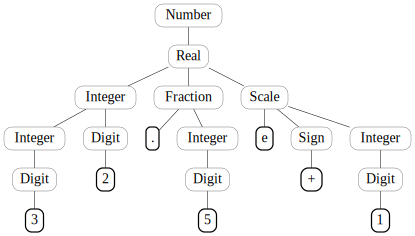

In [ ]:
# l'albero

ProductionGraph(d)

### E le ε-produzioni?

In [ ]:
INPUT = tuple('32.5')

In [ ]:
Rp = cyk(Gp_cnf, INPUT)
Rε = {A for A in Gp_cnf.N if (ε, ) in Gp_cnf.alternatives(A)}
for i in range(1, len(INPUT) + 2): Rp[i, 0] = Rε

In [ ]:
leftmost_prods = get_original_leftmost_prods(G, make_derives(Rp, INPUT), len(INPUT))

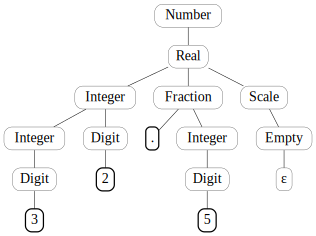

In [ ]:
ProductionGraph(Derivation(G).leftmost(leftmost_prods))    